<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/Udacity%3A%20Intro%20to%20TensorFlow%20for%20DL/TFSD_S1L2_Colab3_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Dataset

It consists of 28 by 28 pixel gray-scale images(784 bytes) of clothing and contains images of t-shrits and tops, sandals and even ankle boots.

There are 10 labels to use.

In total, it contains 70,000 images which is plenty for us to get started with.


## The Rectified Linear Unit (ReLU)
Let's talk about ReLU and how it gives our Dense layer more power.

ReLU is a type of activation function and used most commonly and serves as a good default.

<a href = "https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning">[Kaggle] Article on ReLU in Deep Learning</a>


# Classifying Images of Clothing
* Before we start, let's enable GPU execution to speed things up.


    Runtime > Change runtime type > Harware accelerator > GPU

## Install and import dependencies

We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provide several sample datasets to work with. We're also using a few helper libraries.

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

2.6.0


## Import the Fashion MNIST dataset

Ypu can access the Fashion MNIST directly from TensorFlow, using the Datasets API.

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Loading the dataset returns metadata as well as a training dataset and test dataset.

- The model is trained using train_dataset
- The model is tested using test_dataset

The images are 28 X 28 arrays, with pixel values in the range [0, 255].

The labels are an array of integers, in the range of [0, 9].

In [4]:
class_name = ['T-shirt/top', 'Trouser','Pullover','Dress','Coat',
              'Sandal','Shirt','Sneaker','Bag','Ankle boot']

### Explore the data

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


## Preprocess the data
The value of each pixel in the image data is an integer in the range [0, 255]. For the mnodel to work properly, these values need to be normalized to the range [0, 1].

In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the processed data

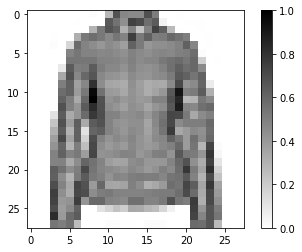

In [7]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break

image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

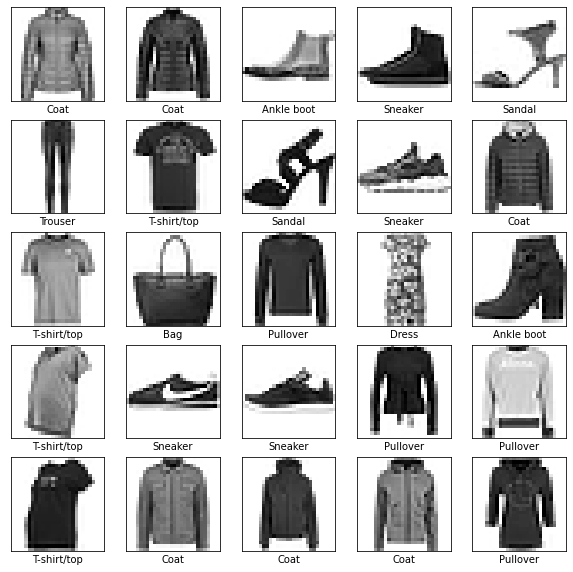

In [8]:
plt.figure(figsize=(10,10))

i = 0

for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_name[label])
  i += 1

plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.



### Setup the layers
The basic block of a neural network is the layer. A layer extracts a representation from the data fed into it.

In [9]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compile the model
- **Loss Function**: An algorithm for measuring how far the model's outputs are from the desired output.

- **Optimizer**: An algorithm for adjusting the inner parameters of the model in order to minimize loss.

- **Metrics**: Used to monitor the training and testing step.

In [10]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

### Train the model
Let's define the iteration behavior for the train dataset:

1. Repeat forever by specifying `dataset.repeat()`
2. The `dataset.shuffle(60000)` randomize the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updationg the variables.

Training is performed by calling the `model.fit` method:

1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5*60000 = 300000 examples.

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 20s 5ms/step - loss: 0.4957 - accuracy: 0.8256
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3667 - accuracy: 0.8667
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3367 - accuracy: 0.8782
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3127 - accuracy: 0.8842
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2957 - accuracy: 0.8901


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.89 on the training data.

### Evaluate accuracy

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print(f'Accuracy on test dataset: {test_accuracy}')

313/313 [==============================] - 1s 4ms/step - loss: 0.3909 - accuracy: 0.8612
Accuracy on test dataset: 0.8611999750137329


Normaly, the accuracy on the test dataset is smaller than that on the train dataset. 

It is because the model was trained on the train dataset.

### Make predictions and explore


In [19]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [20]:
predictions.shape

(32, 10)

Here, the model has predicted the label for each image in the testing set.

In [21]:
# The first prediction
predictions[0]

array([2.2542449e-06, 2.2529522e-07, 1.4132494e-02, 5.4380644e-07,
       9.8172748e-01, 9.5228068e-11, 4.1293008e-03, 2.5832588e-11,
       7.7589038e-06, 1.6180857e-11], dtype=float32)

A prediction is an array of 10 numbers. These describe the 'confidence' of the model that the image corresponds to each of the 10 different articles of clothing.

In [22]:
np.argmax(predictions[0])

4

In [23]:
test_labels[0]

4

The model successfully predict the label of example.

We can graph this to look at the full set of 10 channels.

In [27]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_name[predicted_label],
                            100*np.max(predictions_array),
                            class_name[true_label]),
                            color = color)

In [28]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#777777')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

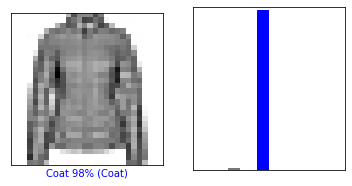

In [29]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

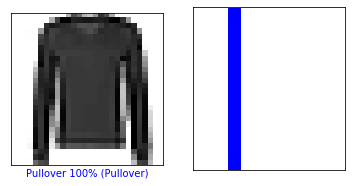

In [30]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

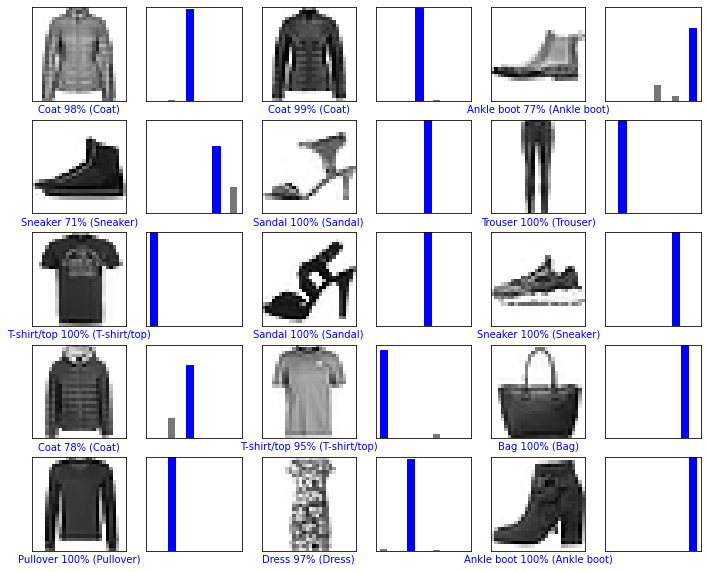

In [32]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [33]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once.

So even though we're using a single image, we need to add it to a list.

In [34]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [35]:
predictions_single = model.predict(img)
print(predictions_single)

[[2.2542447e-06 2.2529520e-07 1.4132512e-02 5.4380536e-07 9.8172736e-01
  9.5228055e-11 4.1293018e-03 2.5832631e-11 7.7589320e-06 1.6180919e-11]]


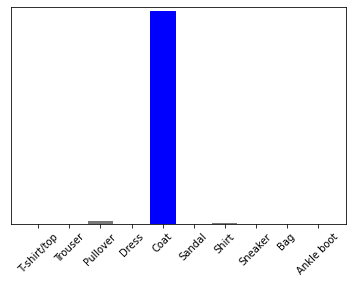

In [38]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_name, rotation= 45)

In [39]:
np.argmax(predictions_single[0])

4

## Exercises
Experiment with diffferent models and see how the accuracy results differ. In particular change the following parameters:
 
  - Set training epochs set to 1
  - Number of neurons in the Dense layers between the Flatten and the final Dense, experiment with different units in these layers
  - Don't normalize the pixel values, and see the effect that has

***The new terms related to ReLU***
- **Flattening:** The process of converting a 2d image into 1d vector
- **ReLU:** An activation function that allows a model to solve nonlinear problems
- **Softmax:** A function that provides probabilities for each possible output class
- **Classification:** A machine learning model used for distinguishing among two or more output categories